In [278]:
from sysid.ss_cupy_fp16 import StateSpaceDiscreteLinear, StateSpaceDataList, StateSpaceDataArray
from sysid.subspace_cupy_fp16 import subspace_det_algo1, prbs, nrms, symmetric_mean_absolute_percentage_error
import time
import pandas as pd
import cupy as np
import numpy
import matplotlib.pyplot as plt

In [279]:
tf = 150  # 365 * 5
dt = 1
plot_stuff = True

u_dimensions = 2
y_dimensions = 2

data_u = np.random.randn(u_dimensions, tf)  # 40 * 45
# data_y = np.random.randn(3, tf)  # 40 * 45
white_noise = 0.1 *  np.random.randn(y_dimensions, tf)
uniform_noise = 0.1 *  np.random.rand(y_dimensions, tf)
data_y = data_u[0:y_dimensions,:] + white_noise + uniform_noise # 40 * 45

In [280]:
print("data_u.shape: {}, data_y.shape: {}".format(data_u.shape, data_y.shape))
print("MIMO [{} IN, {} OUT], {} time-steps.".format(data_u.shape[0], data_y.shape[0], data_u.shape[1]))

def f_prbs_4d(t, x, i):
    return np.array([data_u[:, i]], dtype=numpy.float16).T

start_time = time.time()  # Serial
ss3_id = subspace_det_algo1(y=data_y, u=data_u,
    f=5,  # 5 Forward steps
    p=5,  # 5 Backward steps
    s_tol=0.01,  # 0.2
    dt=dt,
    order=-1)
print("--- GPU Execution time:\t\t{} seconds".format(time.time() - start_time))

data_u.shape: (2, 150), data_y.shape: (2, 150)
MIMO [2 IN, 2 OUT], 150 time-steps.
--- GPU Execution time:		0.14676380157470703 seconds


In [281]:
data3_id = ss3_id.simulate(
    f_u=f_prbs_4d,
    x0=np.array([np.zeros(ss3_id.A.shape[0])], dtype=numpy.float16).T,
    tf=tf)


Total NRMSE: 0.118
Total SMAPE: 24.41%


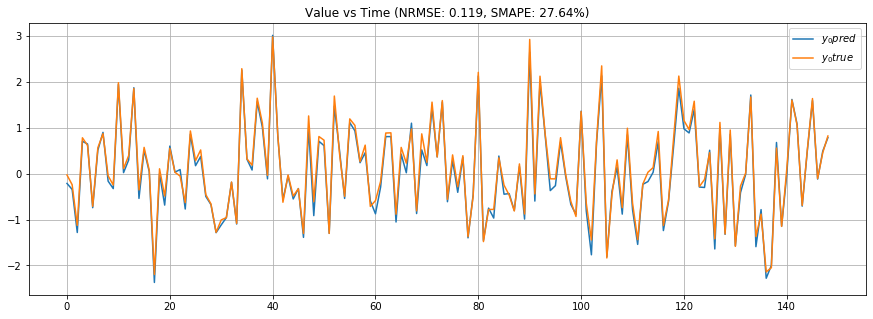

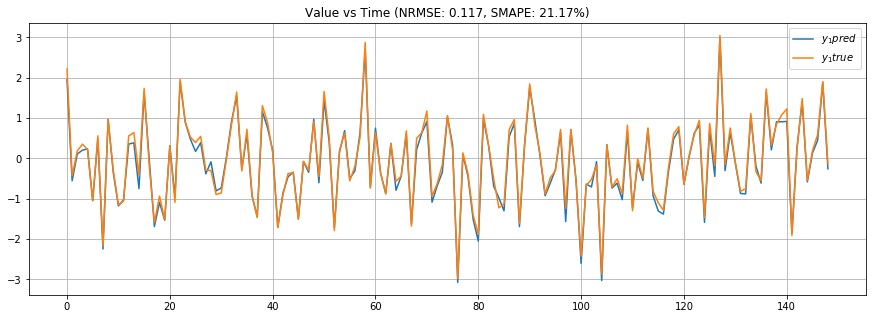

In [282]:
timesteps = data3_id.t.tolist()
for i in range(y_dimensions):    
    plt.figure(figsize=(15,5))
    # plt.plot(timesteps, data3_id.u[:,i,:][0].tolist(), label='$u_{:d}$'.format(i))
    plt.plot(timesteps, data3_id.y[:,i,:][0].tolist(), label='$y_{:d} pred$'.format(i))   
    plt.plot(timesteps, data_y[i,:-1].tolist(), label='$y_{:d}true$'.format(i))     
    plt.legend()
    plt.grid()
    plt.title("Value vs Time (NRMSE: {}, SMAPE: {}%)".format(round(float(nrms(np.array(data_y[i, :-1]),np.array(data3_id.y[:,i,:][0]))), 3), round(float(symmetric_mean_absolute_percentage_error(np.array(data_y[i, :-1]),np.array(data3_id.y[:,i,:][0]))), 2)))

print("Total NRMSE: {}".format(round(float(nrms(np.array(data_y[:, :-1]),np.array(data3_id.y[0]))), 3)))
print("Total SMAPE: {}%".format(round(float(symmetric_mean_absolute_percentage_error(np.array(data_y[:, :-1]),np.array(data3_id.y[0]))), 2)))